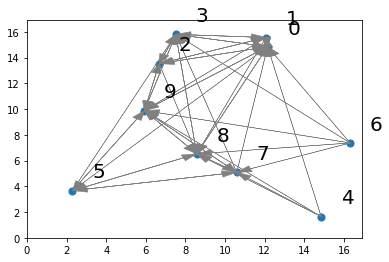

In [30]:
import random

class Sensor:
    def __init__ (self, sensor_id, wsn):
        self._wsn = wsn
        self.id = sensor_id
        self.x = 0
        self.y = 0
        self.sensing_range = 0
        
        self.drift = random.uniform(0.8, 1.2)
        self.offset = random.uniform(0, 0.1)
        
        
    def global_to_local_clock(self, g_clock):
        return g_clock * self.drift + self.offset
        
    def local_to_global_clock(self, l_clock):
        return (l_clock - self.offset) / self.drift
        
    def set_loc(self, x, y):
        self.x, self.y = x, y
        
class WirelessSensorNetwork:
    def __init__(self, nnode, connectivity=10, sensing_range=30, seed=3, Sensor_class=Sensor):
        random.seed(seed)
        
        self.sensors = [Sensor_class(i, self) for i in range(nnode)]
        for s in self.sensors:
            s.sensing_range = sensing_range + random.randint(-sensing_range/2,sensing_range/2)
            
        sensor_density = (connectivity + 1) / (3.1415 * sensing_range ** 2)

        area = nnode / sensor_density
        self.edge = area**0.5
        
        self.scatter_sensor()
        
    def scatter_sensor(self):
        for s in self.sensors:
            s.set_loc(random.uniform(0, self.edge), random.uniform(0, self.edge))
        cnt = 0
        for i in range(len(self.sensors)):
            cnt += len(self.neighborsID(sensorID=i))
        cnt /= len(self.sensors)
        
    def neighborsID(self, sensorID):
        ts = self.sensors[sensorID]
        return [s.id for s in self.sensors if abs((s.x - ts.x)**2) + abs((s.y - 
                                                                          ts.y)**2) < s.sensing_range ** 2 ]
    
    def draw(self):
        
        fig, ax = plt.subplots(1,1)
        ax.scatter([s.x for s in self.sensors], [s.y for s in self.sensors], s=50)
        for s in self.sensors:
            ax.text( s.x+1,s.y+1,str(s.id), fontsize=20)
            neighbors = self.neighborsID(s.id)
            for nid in neighbors:
                if nid == s.id:
                    continue
                sn = self.sensors[nid]
                plt.arrow(s.x,s.y,sn.x-s.x,sn.y-s.y, lw=0.5, length_includes_head=True, head_width=0.5, color='gray')
                
        plt.ylim([0,self.edge])
        plt.xlim([0,self.edge])
        plt.plot()
        

import matplotlib.pylab as plt
%matplotlib inline

wsn = WirelessSensorNetwork(nnode=10, connectivity=10, sensing_range=10, Sensor_class=Sensor)
wsn.draw()

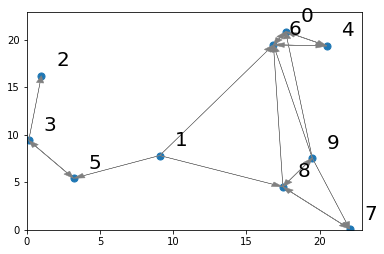

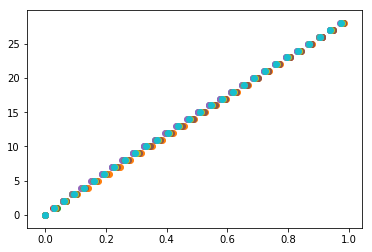

In [51]:
class SensorAlgo(Sensor):
    
    def __init__ (self, sensor_id, wsn):
        super().__init__(sensor_id, wsn)
        self.wsn = wsn
        self.id = sensor_id
    
    def init_sim(self, nround):
        
        self.method = 2
        self.time_wheel = [[] for i in range(nround)]
        self.pulse_time = []
        
        self.round = 0
        self.latest_broadcast_id = 0
        self.clock_period = 0.03
        
    def broadcast(self, info):
        
        local_time = self.global_to_local_clock(info['time'])
        
        self.pulse_time.append(local_time)
            
        ids = self.wsn.neighborsID(self.id)

        next_round = (self.round + 1) % len(self.time_wheel)
        
        q = []
        for j in ids:
            q.append({'type':'receive', 'id':j, 'round':next_round, 'time': info['time'], 'from': self.id})
            
        self.time_wheel[self.round] = []
        self.round = next_round
        
        #if self.id == 3:
        #    print('------------------------')
        #    print('broadcast at ', info['time'], ' round', self.round)
        #    print('------------------------')

        return q #+ self.register_broadcast(self.local_to_global_clock(next_pulse))
    
    import math
    def receive(self, info):

        local_time = self.global_to_local_clock(info['time'])
        self.time_wheel[info['round']].append(local_time)

        corr1, corr2 = self.predict_next_pulse()
        
        #if self.id == 4:
        #    print('----receive---', 'from id', info['from'], 'round', info['round'])
        #    print('time wheel', self.time_wheel)
        #    print('round', self.round)
        #    print('next pulse', corr1 + corr2)
            
        next_pulse = (corr1 + corr2) 
        
        return self.register_broadcast(self.local_to_global_clock(next_pulse))
    
    def register_broadcast(self, time):
        self.latest_broadcast_id += 1
        return [{'type':'broadcast', 'time':time, 'latest_broadcast_id':self.latest_broadcast_id, 'id':self.id}]
    
    def predict_next_pulse(self):
        # without correction
        if self.method == 0:
            corr1 = self.pulse_time[-1]
            corr2 = self.clock_period
            
        # only offset compensation
        elif self.method == 1:
            
            corr1 = self.pulse_time[-1] if len(self.time_wheel[self.round]) == 0 else sum(self.time_wheel[self.round])/len(self.time_wheel[self.round])
            corr2 = self.clock_period
        
        # offset and drift compensation
        else:
            corr1 = self.pulse_time[-1] if len(self.time_wheel[self.round]) == 0 else sum(self.time_wheel[self.round])/len(self.time_wheel[self.round])
            corr2 = (corr1 - self.pulse_time[0]) / (len(self.pulse_time)-1) if len(self.pulse_time) > 3 else self.clock_period
            
        return corr1, corr2
        
    #register_broadcast(i, corr1 + corr2 + noise)
            

def simulation(wsn):
    
    start_time = 0
    end_time = 1
    
    for s in wsn.sensors:
        s.init_sim(2)
    
    q = sum([s.register_broadcast(start_time) for s in wsn.sensors], [])
    
    while q[0]['time'] < end_time:
        event = q.pop(0)
        sensor = wsn.sensors[event['id']]
        
        if event['type'] == 'broadcast' and event['latest_broadcast_id'] == sensor.latest_broadcast_id:
            q += sensor.broadcast(event)
            
        elif event['type'] == 'receive':
            q += sensor.receive(event)
            
            
        q.sort(key=lambda x: x['time'])

wsn = WirelessSensorNetwork(nnode=10, connectivity=5, sensing_range=10, Sensor_class=SensorAlgo, seed=9)
wsn.draw()
plt.show()

simulation(wsn) 
for s in wsn.sensors:
    plt.scatter(list(map(lambda t:s.local_to_global_clock(t), s.pulse_time)), list(range(len(s.pulse_time))))
    
    
    